In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Higgs.tools.ImplementationUtils import (
    implementPairDecayLimit,
    fromHB5Table1,
    implementPairProductionLimit,
)
from Higgs import bounds as HB
from Higgs import predictions as HP
from Higgs import Predictions
from scipy.interpolate import griddata
import os, sys

sys.path.insert(0, os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))))
import MassResolutions as resolution


# ATLAS 13TeV LHC

## `H > S S > WW WW` [1811.11028](https://arxiv.org/abs/1811.11028)

This limit provides three mass slices. Two of those keep mS fixed, one at 125GeV and one at 135GeV. We combine those two into a 2D limit.

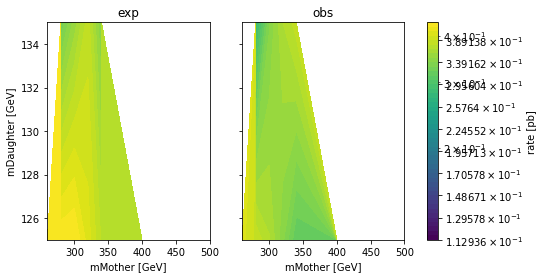

Looks good. Saving this to ggH_LHC13_ATLAS_36.json


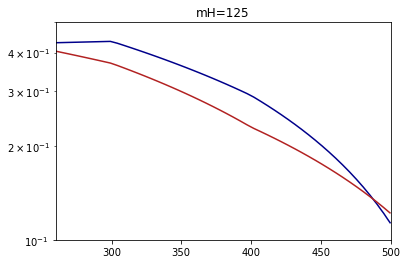

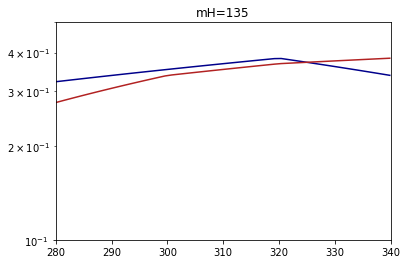

In [2]:
refBr125 = HP.SMHiggs(125).br("WW") ** 2
df125 = pd.DataFrame(
    {
        "mMother": [260, 300, 400, 500],
        "exp": refBr125 * np.array([9.9, 10, 6.7, 2.6]),
        "obs": refBr125 * np.array([9.3, 8.5, 5.3, 2.8]),
        "mDaughter1": 125,
    }
)

refBr135 = HP.SMHiggs(135).br("WW") ** 2
df135 = pd.DataFrame(
    {
        "mMother": [280, 300, 320, 340],
        "exp": refBr135 * np.array([2.1, 2.3, 2.5, 2.2]),
        "obs": refBr135 * np.array([1.8, 2.2, 2.4, 2.5]),
        "mDaughter1": 135,
    }
)

dfConc = pd.concat([df125, df135])
XX, YY = np.meshgrid(np.unique(dfConc.mMother), np.unique(dfConc.mDaughter1))
df = pd.DataFrame({"mMother": XX.flatten(), "mDaughter1": YY.flatten()})
df["exp"] = griddata(
    dfConc[["mMother", "mDaughter1"]],
    dfConc.exp,
    df[["mMother", "mDaughter1"]],
    fill_value=1e6,
)
df["obs"] = griddata(
    dfConc[["mMother", "mDaughter1"]],
    dfConc.obs,
    df[["mMother", "mDaughter1"]],
    fill_value=1e6,
)


limitFile = implementPairDecayLimit(
    "1811.11028",
    {
        "production": ["ggH"],  # b-jet veto
        "firstDecay": ["WW"],
        "secondDecay": ["WW"],
    },
    "Aux. Tab. 6",
    df,
    idSuffix=1,
    massResolution={
        "firstDaughter": {"absolute": 10, "relative": 0},  # guess
        "secondDaughter": {"absolute": 10, "relative": 0},
        "mother": resolution.WW["qqlnu"],  # guess
    },
)
lim = HB.Limit(limitFile)

pred = Predictions()
hh = pred.addParticle(HP.NeutralScalar("hh"))
h1 = pred.addParticle(HP.NeutralScalar("h1"))
hh.setDecayWidth("h1", "h1", 1.0)
h1.setDecayWidth("WW", 1)
r = np.linspace(0.1, 0.5)


def testAgainstLimit(mass, rate):
    hh.setMass(mass)
    hh.setCxn("LHC13", "ggH", rate)
    app = lim.apply(pred)
    if len(app) == 0:
        print("Limit not applied for ", mass, rate)
        return (0, 0)
    return (app[0].expRatio(), app[0].obsRatio())


for mass, hm in ((125, np.linspace(260, 500)), (135, np.linspace(280, 340))):
    h1.setMass(mass)
    test = np.frompyfunc(testAgainstLimit, 2, 2)
    XX, YY = np.meshgrid(hm, r)
    expR, obsR = test(XX, YY)
    fig, ax = plt.subplots()
    ax.set_yscale("log")
    expCc = ax.contour(hm, r, expR, levels=[1], colors=["darkblue"])
    obsCc = ax.contour(hm, r, obsR, levels=[1], colors=["firebrick"])
    expCc.collections[0].set_label("expRatio = 1")
    obsCc.collections[0].set_label("obsRatio = 1")
    ax.set_title("mH={}".format(mass))
    plt.show()


## `H > S S > WW WW` with mH = 340GeV [1811.11028](https://arxiv.org/abs/1811.11028)

This limit provides three mass slices. This third mass slice is orthogonal to the two others and keeps the mass of the mother particle fixed.

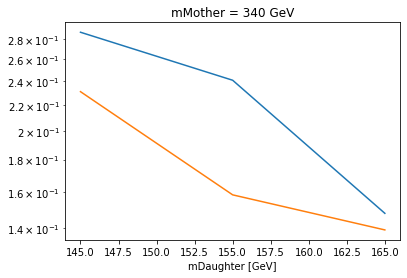

Looks good. Saving this to ggH_H_LHC13_ATLAS_36.json


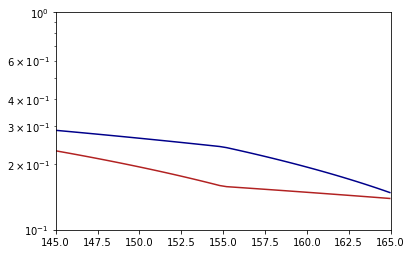

In [3]:
df = pd.DataFrame(
    {
        "mDaughter1": [145, 155, 165],
        "exp": [0.82, 0.38, 0.17],
        "obs": [0.66, 0.25, 0.16],
        "mMother": 340,
    }
)

refBr = np.array([HP.SMHiggs(m).br("WW") ** 2 for m in df.mDaughter1])
df.exp *= refBr
df.obs *= refBr

limitFile = implementPairDecayLimit(
    "1811.11028",
    {
        "production": ["ggH"],  # b-jet veto
        "firstDecay": ["WW"],
        "secondDecay": ["WW"],
    },
    "Aux. Tab. 8",
    df,
    idSuffix=2,
    massResolution={
        "firstDaughter": {"absolute": 20, "relative": 0},  # guess
        "secondDaughter": {"absolute": 20, "relative": 0},
        "mother": resolution.WW["qqlnu"],  # guess
    },
    prefix="ggH_H",
)
lim = HB.Limit(limitFile)

pred = Predictions()
hh = pred.addParticle(HP.NeutralScalar("hh"))
h1 = pred.addParticle(HP.NeutralScalar("h1"))
hh.setDecayWidth("h1", "h1", 1.0)
hh.setMass(340)
h1.setDecayWidth("WW", 1)
hm = np.linspace(145, 165)
r = np.linspace(0.1, 1)


def testAgainstLimit(mass, rate):
    h1.setMass(mass)
    hh.setCxn("LHC13", "ggH", rate)
    app = lim.apply(pred)
    if len(app) == 0:
        print("Limit not applied for ", mass, rate)
        return (0, 0)
    return (app[0].expRatio(), app[0].obsRatio())


test = np.frompyfunc(testAgainstLimit, 2, 2)
XX, YY = np.meshgrid(hm, r)
expR, obsR = test(XX, YY)
fig, ax = plt.subplots()
ax.set_yscale("log")
expCc = ax.contour(hm, r, expR, levels=[1], colors=["darkblue"])
obsCc = ax.contour(hm, r, obsR, levels=[1], colors=["firebrick"])
expCc.collections[0].set_label("expRatio = 1")
obsCc.collections[0].set_label("obsRatio = 1")


## non-res `pp > hh > WW WW` [1811.11028](https://arxiv.org/abs/1811.11028)


In [2]:
df = pd.DataFrame({"m": [125], "obs": 5.3, "exp": 3.8})
limitFile = implementPairProductionLimit(
    "1811.11028",
    {"firstDecay": ["WW"], "secondDecay": ["WW"]},
    "p.10",
    df,
    idSuffix=3,  # 1 and 2 are the resonant mass slices
    massResolution={
        "firstParticle": {"absolute": 20, "relative": 0},  # guess
        "secondParticle": {"absolute": 20, "relative": 0},
    },
)

lim = HB.Limit(limitFile)

pred = Predictions()
hh = pred.addParticle(HP.NeutralScalar("hh"))
hh.setCxn("LHC13", "pair", 1.0)
hh.setDecayWidth("WW", 1.0)
hh.setMass(125)
res = lim.apply(pred)
print(res)
assert np.isclose(res[0].obsRatio(), 1.0 / df.obs[0])
assert np.isclose(res[0].expRatio(), 1.0 / df.exp[0])


Looks good. Saving this to nonres_LHC13_ATLAS_36.json
[<Higgs.bounds.AppliedLimit limitId: 1811110283, obsRatio: 0.189, expRatio: 0.263, for: ["hh", "+", "hh"]>]
